In [1]:
from do_pset import *

# Q1
### a.
See the simulator.py file to see the code for running the simulations and more detailed comments about how each of hte functions work. However the outline of the simulations is as follows:

I first initialize a box with 100 particles, passing in the parameters of the simulation, such as particle radius and box size (in cm), initial energy (in ergs) and particle masses (in grams). These particles are given uniformly random positions in the box, provided there are no initial collisions, which are determined by checking two conditions:
$$
||\vec{x_1} - \vec{x_2}|| \leq r1 + r2
$$
which checks for overlap, and 
$$
2(\vec{x_1} - \vec{x_2})\cdot(\vec{v_1} - \vec{v_2}) \leq 0
$$
which checks that the relative velocities of the particles move towards each other.

For every time step (lasting 1s) I first move particles following their current velocities. I then check for collisions with the box walls, i.e. when the partcle is within a radius of the edge of the box. I then change the sign of the velocity perpendicular to the wall, which conserves energy and momentum. I then check for collisions between particles using the same conditions as above. These collisions are resolved as follows, using equations I obtained from wikipedia:

$$
\vec{v'_{1}} = \vec{v1} - \frac{2 m_2}{m_1 + m_2} \frac{(\vec{v_2} - \vec{v_1}) \cdot (\vec{x_1} - \vec{x_2})}{||\vec{x_1} - \vec{x_2}||^2}(\vec{x_1} - \vec{x_2}) \\
\vec{v'_{2}} = \vec{v2} - \frac{2 m_1}{m_1 + m_2} \frac{(\vec{v_1} - \vec{v_2}) \cdot (\vec{x_2} - \vec{x_1})}{||\vec{x_1} - \vec{x_2}||^2}(\vec{x_2} - \vec{x_1})
$$

These equations conserve both kinetic energy and momentum, essentially changing velocity only along the line of contact between the particles. See [here](https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects) for more details

### b.
See below for initial and final positions and velocities

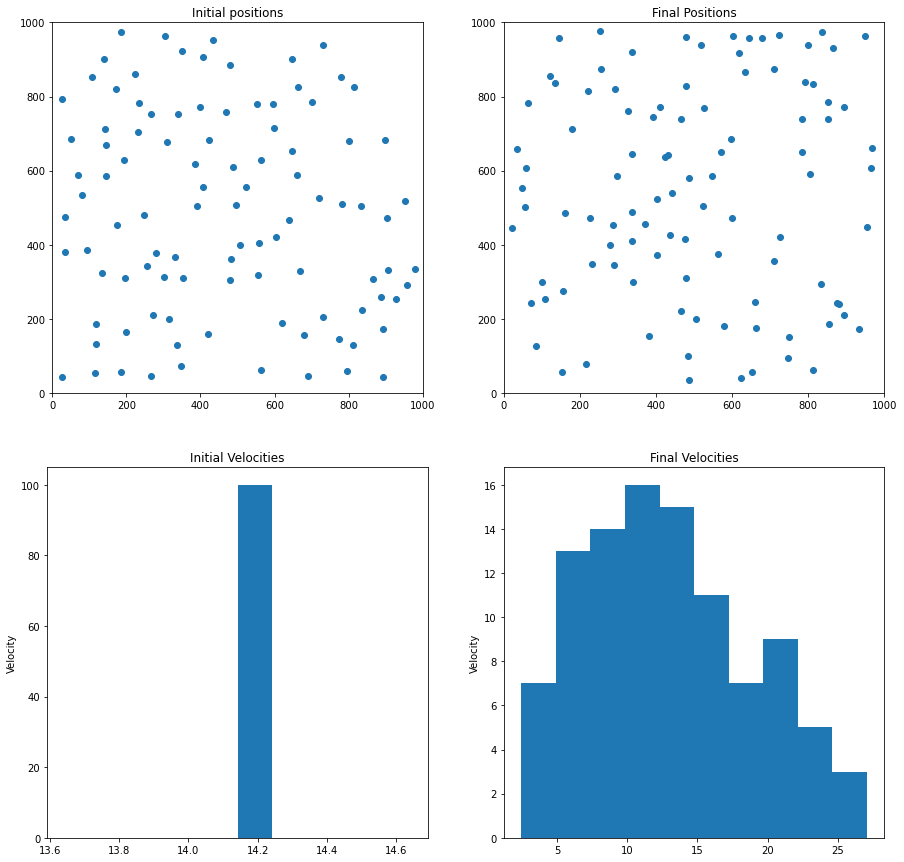

In [2]:
problem1b()

# Q2
### a.
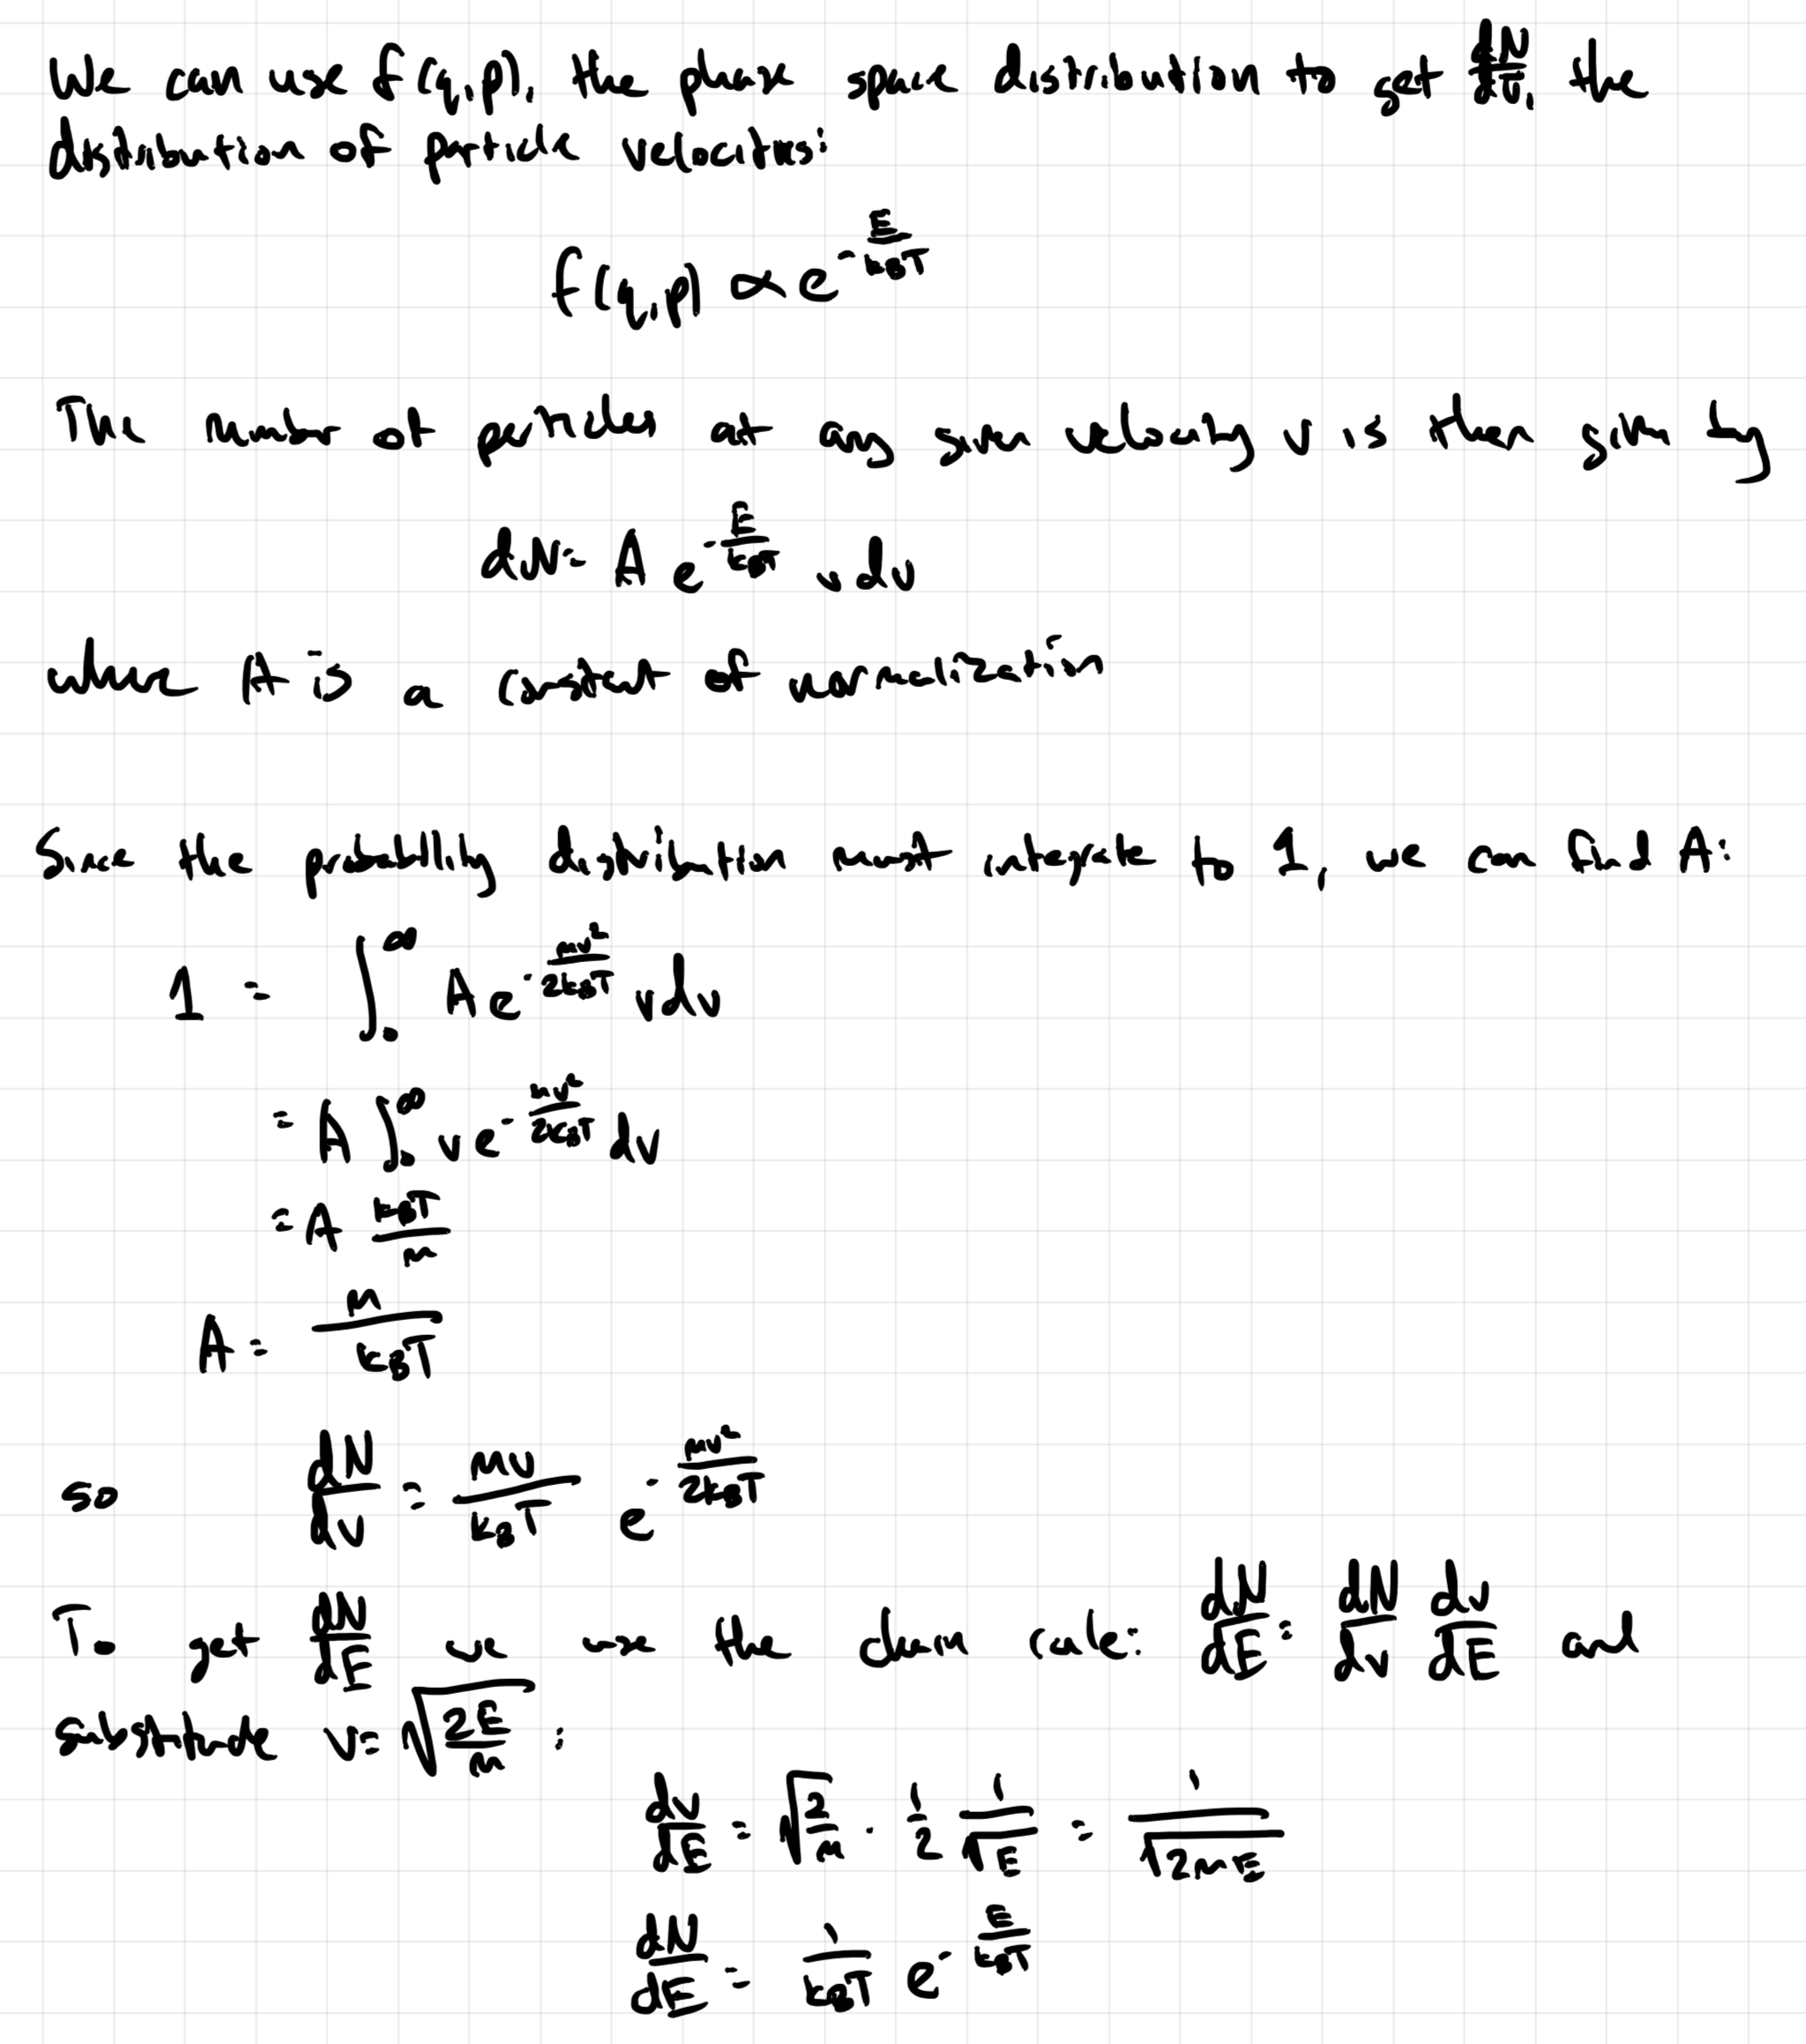

### b. 
The following plots show the numerical distribution of particle energies and velocities, sampled every 100s after a burn-in time of 1500s. The simulation consists of 100 particles of mass 1g and radius 20cm in a box of size 1000cm, each with a random starting position and an initial energt of 100ergs. Note that the analytic distributions match up very well with the simulated distribution.

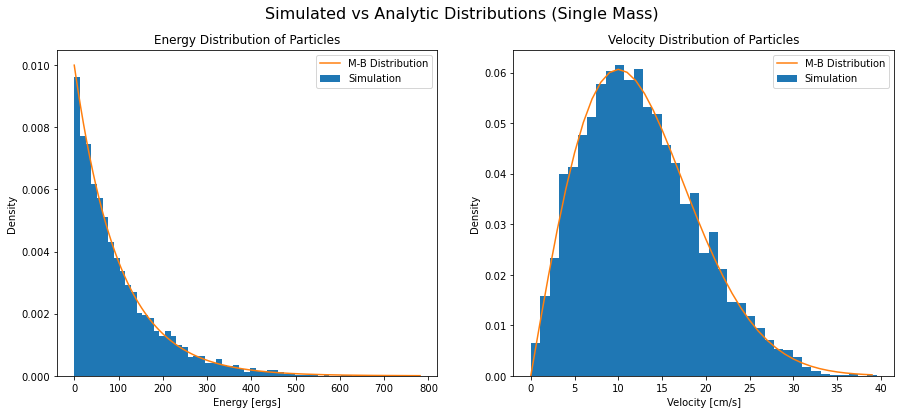

In [3]:
problem2b()

### c.
The parameters of the simulation are identical, except half of the particles have an initial mass of 10g. The energy distribution of the two particle classes are identical Maxwellians, since each particle class still has the same energy. However, the velocity distributions are a mixture of the M-B distribution for each particle class.

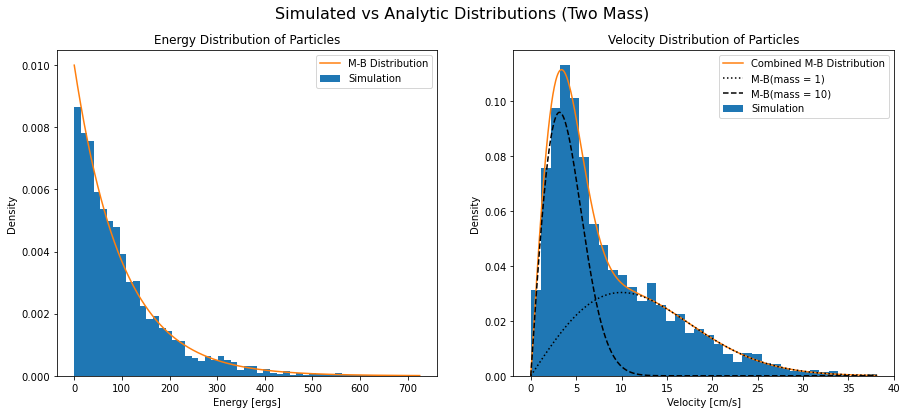

In [4]:
problem2c()

# Q3

### a.
We know that an ideal gas is relaxed when it's distribution of velocities follows the Maxwell-Boltzmann distribution. I perform a 1-sample KS test after every iteration to check whether the distribution of velocities follows the Maxwell-Boltzmann Distribution. I define the system as relaxed (numerically) when the p-value of the 1-sample KS test is greater than 0.05, meaning that there is no evidence that the numerical distribution is different than the analytic at .95 significance level.

### b.
A system has relaxed after it has undergone enough collisions to forget its initial conditions. This occurs after every particle has undergone at least one collision. We can model particle collisions as a stochastic process, assuming that collisions are independent events and the time between collisions is a random variable with mean equal to the mean time between collisions. In lieu of finding the functional form of the probability distribution function of the random variable, I will approximate the time it takes for every particle to experience a collision as X * mean_collision_time, where X is the average number of collisions required to "forget" the initial conditions

Calculating mean collision time:

We expect each particle to under a number of collisions in time $t$ equal to the product of its crossection $\sigma$, distance traveled $v * t$, and the number density of particles $n$:

$$
N_{collisions} = \sigma * v * t * n
$$

letting E equal 1 and solving for $t$:

$$
t = \frac{1}{n v \sigma}
$$

Where $v$ is $v_{rms}$ the root mean square velocity given by $v_{rms} = \sqrt{\frac{2 E}{m}}$ and $\sigma = 2R$, where $R$ is the particle radius. $X=1.3$ appears empirically to line up with the numerical relaxation times.

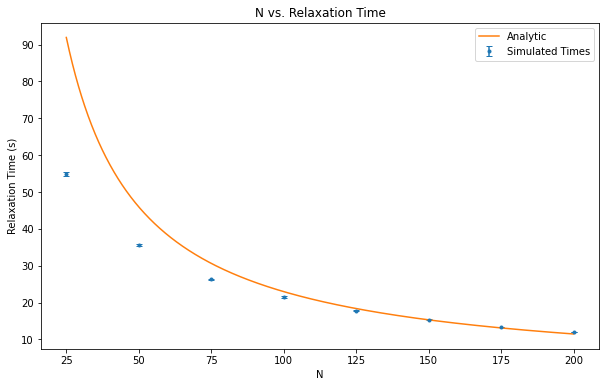

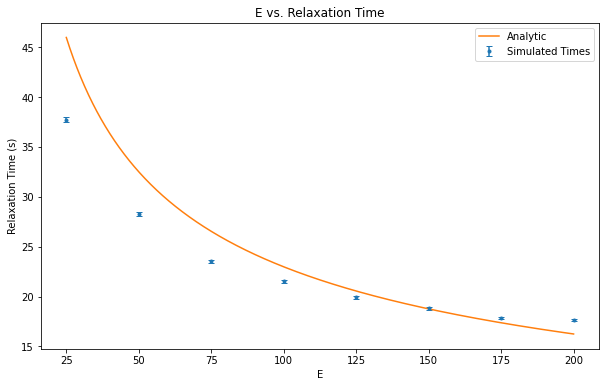

In [5]:
problem3c()

Note that the analytic relaxation times are longer than the simulated times for lower N. This could be a result of the numerical relaxation criteria, which relies on the KS test which could be more likely to pass due to random fluctuations with fewer points.

# Q4
The simulations shows fairly good agreement with the ideal gas law when varying both number of particles (and thus $n$) as well as the initial starting energy ($E=k_BT$). I calculate the simulated pressure by keeping track of the total momentum imparted by the wall and dividing by the perimeter of the box and the time of the simulation.

Since the simulated pressure tends to be higher (and have a sharper slope) than expected given the analytic solution, tihs could be due to bugs in the simulation. I think specifically that the combination of time steps and initial energy leads to particles that move very fast relative to the size of the container, which probably introduces some errors as the particles fly past each other or move fairly far past the boundary of the wall before being reflected. These errors may also contribute to the results in problem 3 as well.

I think the handling of wall collisions, which I currently do as just a change in sign of the perpendicular velocity, might be the reason the theoretical results don't line up perfectly. I could test this out by increasing the box size such that $size >> R$ so that imperfections are not as impactful, or by decreasing the time in each timestep to void particles 

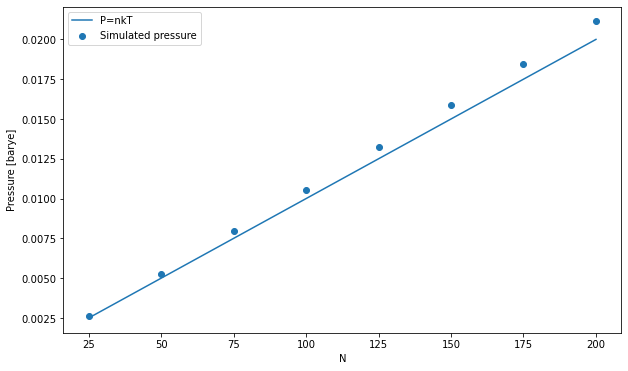

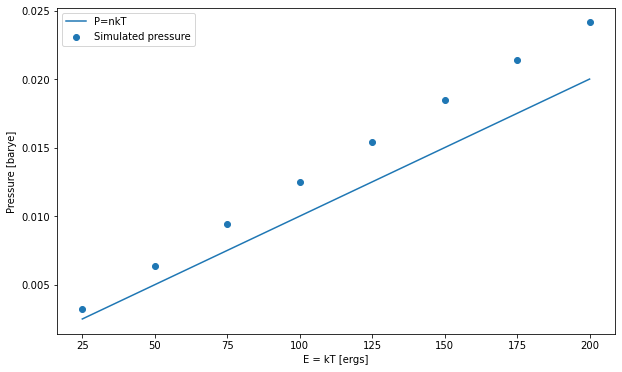

In [6]:
problem4()

# Ignore past this point

### try to find analytic form of relaxation time distribution 

In [7]:
rtdf2 = pd.read_csv("relaxation_times_10000.csv")
samps = rtdf2.set_index(["N", "E", "R"]).loc[(100, 100, 20)]
samps = samps.reset_index()

In [8]:
samps['time'].std() / np.sqrt(10000)

0.047142006882198585

<AxesSubplot:>

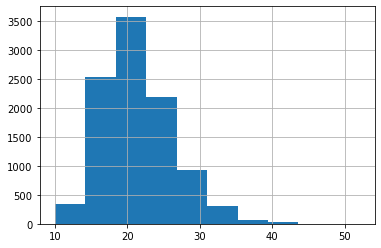

In [9]:
samps['time'].hist()

In [10]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "lognorm", "expon"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        print(dist_name)
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))
    
    xs = np.linspace(data.min(), data.max(), 1000)
    plt.plot(xs, getattr(st, best_dist).pdf(xs, *params[best_dist]))
    plt.hist(data, density=True, bins=10)
    plt.show()
    return best_dist, best_p, params[best_dist]

norm
p value for norm = 1.1350664871686974e-94
exponweib
p value for exponweib = 1.4171742566308626e-21
weibull_max
p value for weibull_max = 0.0
weibull_min
p value for weibull_min = 0.0
pareto
p value for pareto = 0.0
lognorm


/Users/ykwang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for lognorm = 1.859864941869723e-21
expon
p value for expon = 0.0
Best fitting distribution: lognorm
Best p value: 1.859864941869723e-21
Parameters for the best fit: (0.2812596455553594, 5.040483629742508, 15.736810253079108)


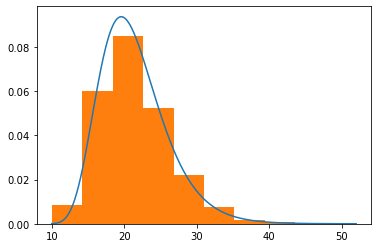

('lognorm',
 1.859864941869723e-21,
 (0.2812596455553594, 5.040483629742508, 15.736810253079108))

In [11]:
get_best_distribution(samps['time'].astype(float))